# Session 4 — Paragraph-Level Analysis
## Measure 4: Paragraph–Summary Similarity (Compressibility)

### What is "Compressibility"?

Imagine you have to summarize a paragraph in one sentence. Some paragraphs are easy to summarize because they focus on one main idea. Others are harder because they jump between multiple topics or include lots of details.

**Compressibility** measures how well a short summary captures the essence of the full paragraph:
- **High compressibility** (high similarity): The summary is very similar to the full paragraph → easy to compress
- **Low compressibility** (low similarity): The summary misses a lot → hard to compress

**Real-world analogy:**
- Easy to summarize: *"The cat sat on the mat. The furry feline rested comfortably on the soft rug."* → Both sentences say the same thing
- Hard to summarize: *"Alice saw a rabbit. The sky was blue. She felt hungry. A clock chimed."* → Each sentence is different!

### What This Notebook Does:

**Step 1**: Create simple summaries
- For each paragraph, we pick the **longest sentence** as our "summary"
- This is a simple trick - longer sentences often contain more key information

**Step 2**: Convert text to numbers (embeddings)
- We use **MiniLM**, a small AI model, to convert both the paragraph and summary into numerical vectors
- These vectors capture the **meaning** of the text (not just words)
- Similar meanings = vectors point in similar directions

**Step 3**: Measure similarity
- We use **cosine similarity** to compare the paragraph vector with its summary vector
- Score close to 1.0 = very similar (highly compressible)
- Score close to 0.0 = very different (not compressible)

**Step 4**: Analyze patterns
- Which paragraphs are easy vs. hard to summarize?
- Does paragraph length affect compressibility?
- How do the two Alice books compare?

### Why This Matters for Modern AI:

**ChatGPT and Token Limits:**
When you chat with ChatGPT, there's a limit to how much text it can "remember" at once (the context window). To fit long documents, AI systems must **compress** information:

1. **Chunking Documents**: 
   - Systems split long documents into paragraphs/chunks
   - They want chunks that are **highly compressible** (main idea is clear)
   - Low-compressibility chunks might get split further or handled specially

2. **RAG Systems** (Retrieval-Augmented Generation):
   - When searching documents to answer questions, RAG prefers well-structured, compressible paragraphs
   - These paragraphs have clear main ideas that are easy to extract and use

3. **Summarization Quality**:
   - High paragraph-summary similarity means the paragraph is **well-focused**
   - This makes automatic summarization more accurate
   - AI can confidently extract key points

4. **Practical Example**:
   - **Good paragraph** (high compressibility): *"Climate change is accelerating. Rising temperatures cause ice to melt. This leads to sea level rise."* → All sentences connect to one theme
   - **Poor paragraph** (low compressibility): *"Climate change is accelerating. Alice likes tea. The rabbit was late."* → Multiple unrelated ideas

This notebook shows you which paragraphs in Carroll's work are well-focused and which jump between ideas!

In [1]:
import re
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- 1. Load Data ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

fellowship_text = load_book('../data/Fellowship.txt')
towers_text = load_book('../data/TwoTowers.txt')
king_text = load_book('../data/TheKing.txt')

c:\Users\vlads\OneDrive\Desktop\nlp\applied-NLP-week1-drafts1\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 2. Core Logic ---
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Patched for 'The King')
    Forces a split on EVERY newline to handle varying file formats.
    """
    # 1. Normalize all newlines to standard \n
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # 2. Split on EVERY single newline (Aggressive Mode)
    # This works for The King (single lines) AND Fellowship (double lines)
    # because empty strings from double lines get filtered out below.
    paras = text.split('\n')
    
    # 3. Clean and Filter
    # We lowered min_words to 5 to catch short dialogue like "Yes." or "No."
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        # Skip empty lines or tiny artifacts
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
            
    return cleaned_paras

def sentence_split(paragraph: str) -> List[str]:
    """Smart sentence splitter that ignores common abbreviations."""
    pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s'
    sentences = re.split(pattern, paragraph.strip())
    return [s.strip() for s in sentences if s.strip()]

def simple_paragraph_summary(paragraph: str, max_sentences: int = 1) -> str:
    """Extractive summary: choose the longest sentence as proxy for importance."""
    sentences = sentence_split(paragraph)
    if not sentences: return ''
    ranked = sorted(sentences, key=lambda s: len(s.split()), reverse=True)
    return ' '.join(ranked[:max_sentences])

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

def summary_similarity_embeddings(paragraphs: List[str], max_sentences: int = 1) -> Tuple[list, list]:
    sims = []
    lengths = []
    for p in paragraphs:
        if len(p.split()) < 5: continue
        
        # 1. Generate Summary
        summary = simple_paragraph_summary(p, max_sentences=max_sentences)
        if not summary: continue
        
        # 2. Compare Summary Vector vs Whole Paragraph Vector
        para_emb = model.encode(p)
        sum_emb = model.encode(summary)
        sim = cosine_similarity(para_emb, sum_emb)
        
        sims.append(sim)
        lengths.append(len(p.split()))
    return sims, lengths

In [3]:
# --- 3. Execution ---
fellowship_paras = split_into_paragraphs(fellowship_text)
towers_paras = split_into_paragraphs(towers_text)
king_paras = split_into_paragraphs(king_text)

print("Processing Fellowship...")
f_sim, f_len = summary_similarity_embeddings(fellowship_paras)
print("Processing Two Towers...")
t_sim, t_len = summary_similarity_embeddings(towers_paras)
print("Processing The King...")
k_sim, k_len = summary_similarity_embeddings(king_paras)

print(f"Fellowship Mean Similarity: {sum(f_sim)/len(f_sim):.3f}")
print(f"Two Towers Mean Similarity: {sum(t_sim)/len(t_sim):.3f}")
print(f"The King Mean Similarity:   {sum(k_sim)/len(k_sim):.3f}")

Processing Fellowship...
Processing Two Towers...
Processing The King...
Fellowship Mean Similarity: 0.688
Two Towers Mean Similarity: 0.682
The King Mean Similarity:   0.760


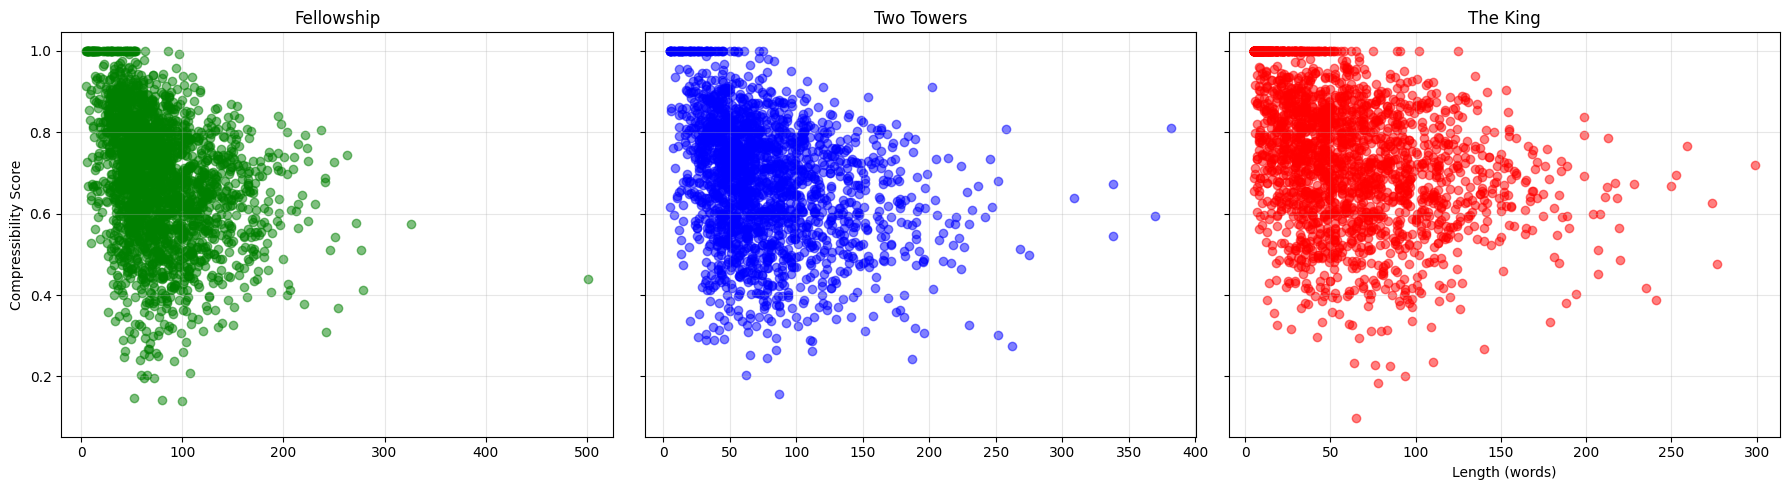

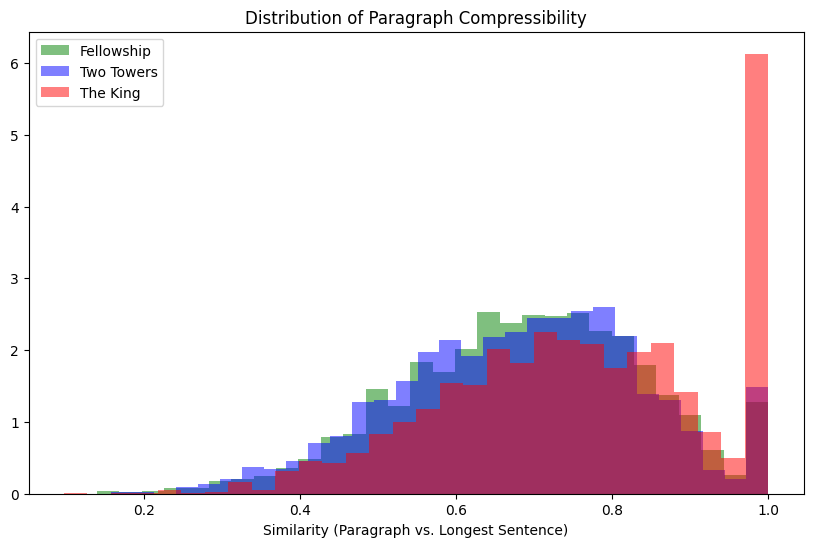

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].scatter(f_len, f_sim, alpha=0.5, color='green')
axes[0].set_title('Fellowship')
axes[0].set_ylabel('Compressibility Score')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(t_len, t_sim, alpha=0.5, color='blue')
axes[1].set_title('Two Towers')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(k_len, k_sim, alpha=0.5, color='red')
axes[2].set_title('The King')
axes[2].set_xlabel('Length (words)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(f_sim, bins=30, alpha=0.5, label='Fellowship', density=True, color='green')
ax.hist(t_sim, bins=30, alpha=0.5, label='Two Towers', density=True, color='blue')
ax.hist(k_sim, bins=30, alpha=0.5, label='The King', density=True, color='red')
ax.set_title('Distribution of Paragraph Compressibility')
ax.set_xlabel('Similarity (Paragraph vs. Longest Sentence)')
ax.legend()
plt.show()

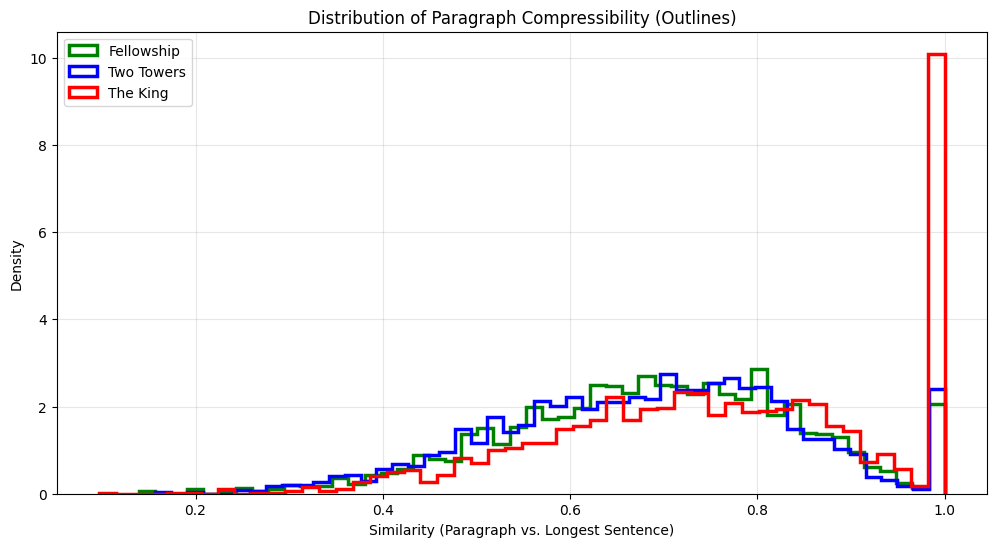

In [5]:
# Option 1: Step Histogram (Clean outlines)
fig, ax = plt.subplots(figsize=(12, 6))

# histtype='step' draws just the outline. linewidth makes it visible.
ax.hist(f_sim, bins=50, label='Fellowship', density=True, 
        color='green', histtype='step', linewidth=2.5)
ax.hist(t_sim, bins=50, label='Two Towers', density=True, 
        color='blue', histtype='step', linewidth=2.5)
ax.hist(k_sim, bins=50, label='The King', density=True, 
        color='red', histtype='step', linewidth=2.5)

ax.set_title('Distribution of Paragraph Compressibility (Outlines)')
ax.set_xlabel('Similarity (Paragraph vs. Longest Sentence)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

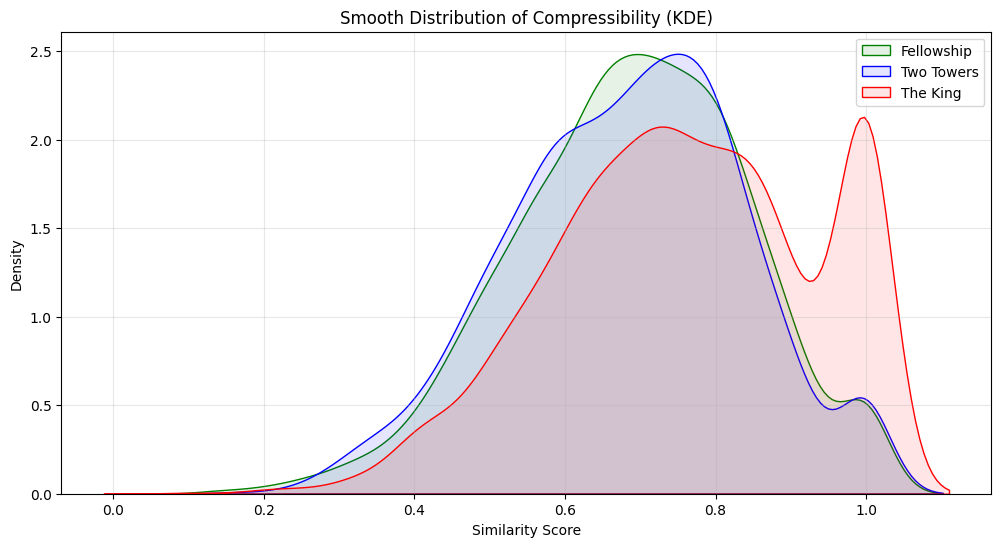

In [6]:
import seaborn as sns

# Option 2: KDE Plot (Smooth Curves)
fig, ax = plt.subplots(figsize=(12, 6))

# fill=True adds a light color, alpha controls transparency
sns.kdeplot(f_sim, color='green', label='Fellowship', fill=True, alpha=0.1, ax=ax)
sns.kdeplot(t_sim, color='blue', label='Two Towers', fill=True, alpha=0.1, ax=ax)
sns.kdeplot(k_sim, color='red', label='The King', fill=True, alpha=0.1, ax=ax)

ax.set_title('Smooth Distribution of Compressibility (KDE)')
ax.set_xlabel('Similarity Score')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

Analyzing Fellowship (Centroid Method)...
Analyzing Two Towers (Centroid Method)...
Analyzing The King (Centroid Method)...

Fellowship Mean Compressibility: 0.752
Two Towers Mean Compressibility: 0.741
The King Mean Compressibility:   0.767


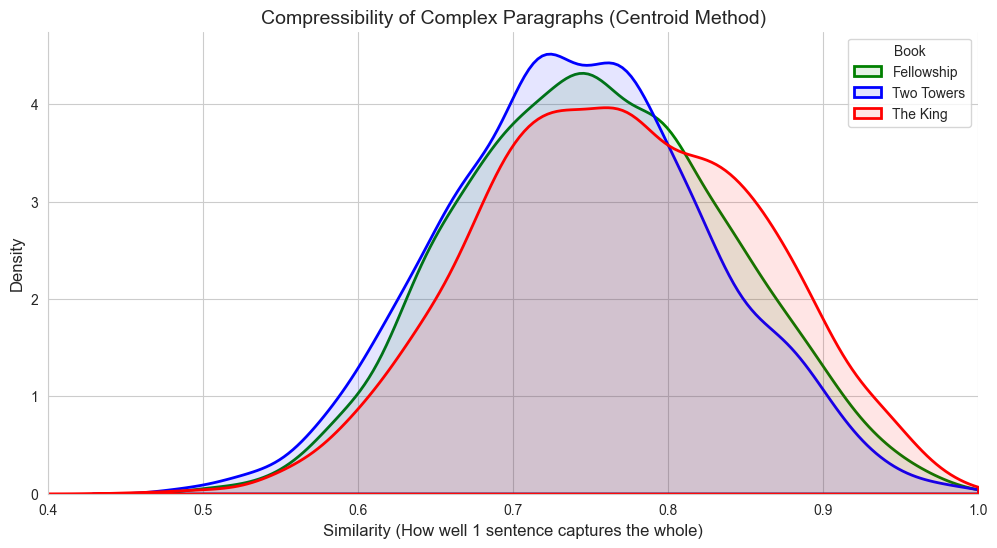

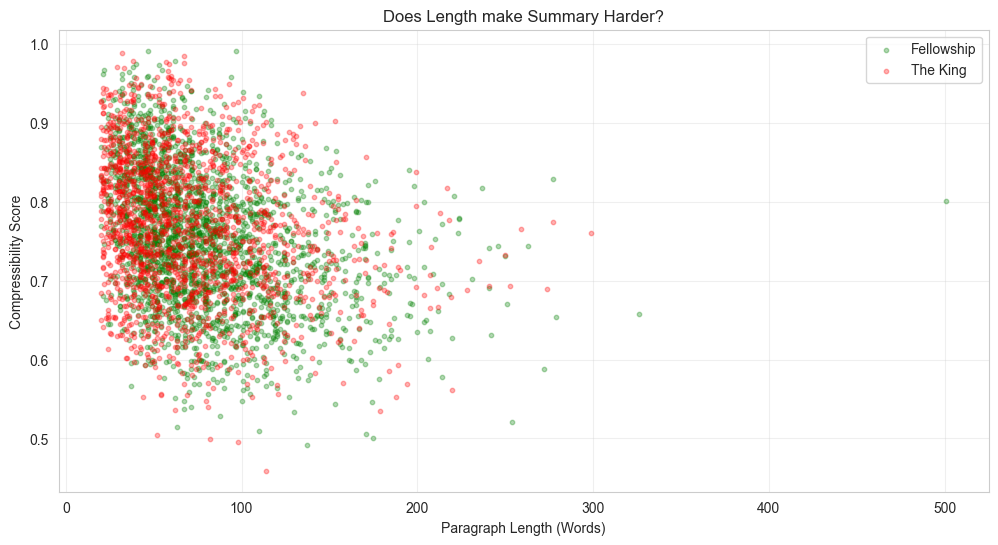

13618

In [7]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from sentence_transformers import SentenceTransformer
import gc

# Initialize Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- 1. ROBUST SPLITTER (From Notebook 5) ---
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    # Strategy 1: Standard Split
    paras = re.split(r'\n\s*\n+', text)
    # Strategy 2: Fallback for dense files
    if len(paras) < 100:
        paras = text.split('\n')
    
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
    return cleaned_paras

def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

# --- 2. IMPROVED CORE LOGIC ---

def sentence_split(paragraph: str) -> List[str]:
    """Smart sentence splitter that ignores common abbreviations."""
    pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s'
    sentences = re.split(pattern, paragraph.strip())
    return [s.strip() for s in sentences if s.strip()]

def get_centroid_compressibility(paragraph: str) -> float:
    """
    ADVANCED SUMMARY METRIC:
    Instead of picking the longest sentence, we find the 'Centroid Sentence'
    (the one most similar to the whole paragraph).
    """
    sents = sentence_split(paragraph)
    
    # FILTER 1: Skip if it's just 1 sentence (Compressibility is irrelevant)
    if len(sents) < 2:
        return None
        
    # FILTER 2: Skip if paragraph is too short to be complex (< 20 words)
    if len(paragraph.split()) < 20:
        return None

    # Encode paragraph and all sentences
    para_emb = model.encode(paragraph)
    sent_embs = model.encode(sents)
    
    # Calculate similarity of EACH sentence to the whole paragraph
    # We want to know: "How well does the BEST single sentence represent the whole?"
    scores = []
    for s_emb in sent_embs:
        denom = (np.linalg.norm(para_emb) * np.linalg.norm(s_emb))
        sim = float(np.dot(para_emb, s_emb) / denom) if denom != 0 else 0.0
        scores.append(sim)
        
    # The "Compressibility Score" is the score of the Best Matching Sentence
    return max(scores)

def analyze_compressibility(paragraphs: List[str]) -> Tuple[list, list]:
    scores = []
    lengths = []
    
    for p in paragraphs:
        score = get_centroid_compressibility(p)
        if score is not None:
            scores.append(score)
            lengths.append(len(p.split()))
            
    return scores, lengths

# --- 3. EXECUTION ---
fellowship_paras = split_into_paragraphs(load_book('../data/Fellowship.txt'))
towers_paras = split_into_paragraphs(load_book('../data/TwoTowers.txt'))
king_paras = split_into_paragraphs(load_book('../data/TheKing.txt'))

print("Analyzing Fellowship (Centroid Method)...")
f_sim, f_len = analyze_compressibility(fellowship_paras)

print("Analyzing Two Towers (Centroid Method)...")
t_sim, t_len = analyze_compressibility(towers_paras)

print("Analyzing The King (Centroid Method)...")
k_sim, k_len = analyze_compressibility(king_paras)

print(f"\nFellowship Mean Compressibility: {sum(f_sim)/len(f_sim):.3f}")
print(f"Two Towers Mean Compressibility: {sum(t_sim)/len(t_sim):.3f}")
print(f"The King Mean Compressibility:   {sum(k_sim)/len(k_sim):.3f}")

# --- 4. IMPROVED VISUALIZATION (KDE) ---
# We use KDE (Smooth Curves) to fix the "overlap" issue in histograms.

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Density
sns.kdeplot(f_sim, fill=True, color='green', label='Fellowship', alpha=0.1, linewidth=2, ax=ax, clip=(0, 1.0))
sns.kdeplot(t_sim, fill=True, color='blue', label='Two Towers', alpha=0.1, linewidth=2, ax=ax, clip=(0, 1.0))
sns.kdeplot(k_sim, fill=True, color='red', label='The King', alpha=0.1, linewidth=2, ax=ax, clip=(0, 1.0))

ax.set_title('Compressibility of Complex Paragraphs (Centroid Method)', fontsize=14)
ax.set_xlabel('Similarity (How well 1 sentence captures the whole)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(title='Book')

# Zoom in on the interesting part (0.4 to 1.0)
# We ignore the very low end because it's rare
ax.set_xlim(0.4, 1.0)

sns.despine()
plt.show()

# Scatter Plot for Length vs Compressibility
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(f_len, f_sim, alpha=0.3, color='green', s=10, label='Fellowship')
ax.scatter(k_len, k_sim, alpha=0.3, color='red', s=10, label='The King')

ax.set_title('Does Length make Summary Harder?')
ax.set_xlabel('Paragraph Length (Words)')
ax.set_ylabel('Compressibility Score')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Cleanup
gc.collect()

Analyzing Fellowship...
Analyzing Two Towers...
Analyzing The King...


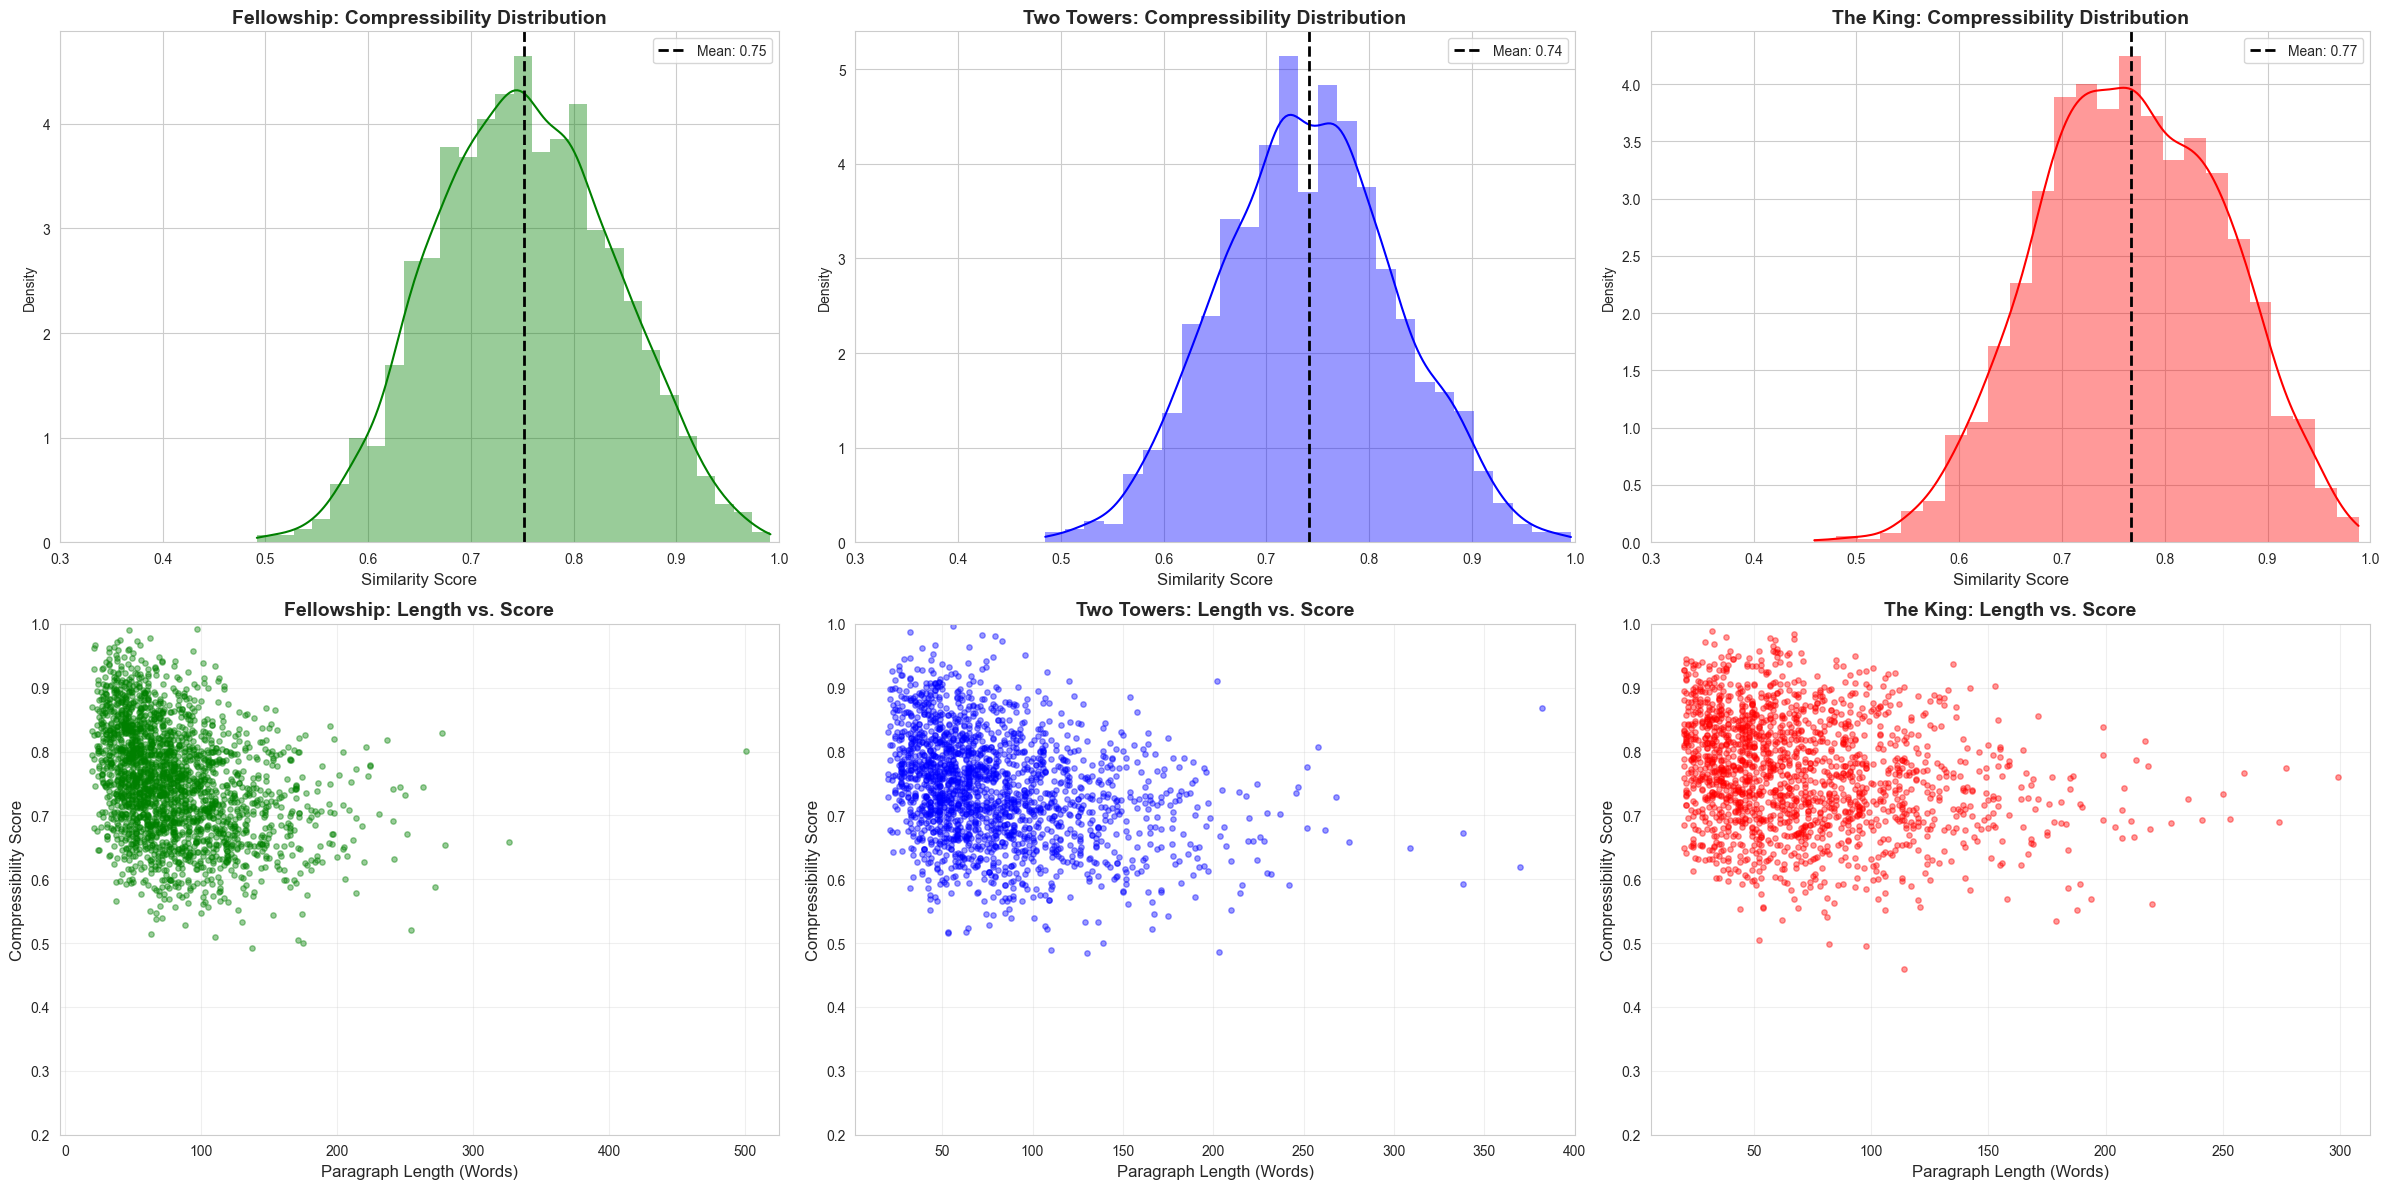

In [8]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from sentence_transformers import SentenceTransformer
import gc

# Load Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: ROBUST LOADING & SPLITTING ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    paras = re.split(r'\n\s*\n+', text)
    if len(paras) < 100:
        paras = text.split('\n')
    
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
    return cleaned_paras

# --- PART 2: SMART COMPRESSIBILITY METRIC ---
def sentence_split(paragraph: str) -> List[str]:
    pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s'
    sentences = re.split(pattern, paragraph.strip())
    return [s.strip() for s in sentences if s.strip()]

def get_centroid_compressibility(paragraph: str) -> float:
    """
    Returns the similarity of the 'Best Representative Sentence' to the whole paragraph.
    Returns None if the paragraph is too simple to analyze.
    """
    sents = sentence_split(paragraph)
    
    # FILTER: Ignore simple dialogue or 1-sentence paragraphs
    if len(sents) < 2 or len(paragraph.split()) < 20:
        return None

    para_emb = model.encode(paragraph)
    sent_embs = model.encode(sents)
    
    # Find which single sentence is closest to the paragraph centroid
    scores = []
    for s_emb in sent_embs:
        denom = (np.linalg.norm(para_emb) * np.linalg.norm(s_emb))
        sim = float(np.dot(para_emb, s_emb) / denom) if denom != 0 else 0.0
        scores.append(sim)
        
    return max(scores)

def analyze_book(name, path):
    print(f"Analyzing {name}...")
    paras = split_into_paragraphs(load_book(path))
    scores = []
    lengths = []
    
    for p in paras:
        score = get_centroid_compressibility(p)
        if score is not None:
            scores.append(score)
            lengths.append(len(p.split()))
            
    return scores, lengths

# --- PART 3: EXECUTION ---
f_sim, f_len = analyze_book('Fellowship', '../data/Fellowship.txt')
t_sim, t_len = analyze_book('Two Towers', '../data/TwoTowers.txt')
k_sim, k_len = analyze_book('The King', '../data/TheKing.txt')

# --- PART 4: VISUALIZATION (SEPARATE GRAPHS) ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(24, 12)) # 2 Rows, 3 Columns

data_map = [
    ('Fellowship', 'green', f_sim, f_len),
    ('Two Towers', 'blue', t_sim, t_len),
    ('The King', 'red', k_sim, k_len)
]

# ROW 1: DISTRIBUTIONS (Histograms)
for i, (name, color, sim, _) in enumerate(data_map):
    ax = axes[0, i]
    
    # Plot Histogram with KDE line
    sns.histplot(sim, ax=ax, color=color, kde=True, stat="density", linewidth=0, alpha=0.4)
    
    # Add Mean Line
    mean_val = np.mean(sim)
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    ax.set_title(f"{name}: Compressibility Distribution", fontsize=14, fontweight='bold')
    ax.set_xlabel("Similarity Score", fontsize=12)
    ax.set_xlim(0.3, 1.0) # Focus on the relevant range
    ax.legend()

# ROW 2: SCATTER PLOTS (Length vs Score)
for i, (name, color, sim, length) in enumerate(data_map):
    ax = axes[1, i]
    
    # Scatter plot
    ax.scatter(length, sim, alpha=0.4, color=color, s=15)
    
    ax.set_title(f"{name}: Length vs. Score", fontsize=14, fontweight='bold')
    ax.set_xlabel("Paragraph Length (Words)", fontsize=12)
    ax.set_ylabel("Compressibility Score", fontsize=12)
    ax.set_ylim(0.2, 1.0)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

[Fellowship] Split Mode: Fallback (Single-Space) | Found: 2446 paragraphs
[Two Towers] Split Mode: Fallback (Single-Space) | Found: 2026 paragraphs
[The King] Split Mode: Fallback (Single-Space) | Found: 2282 paragraphs


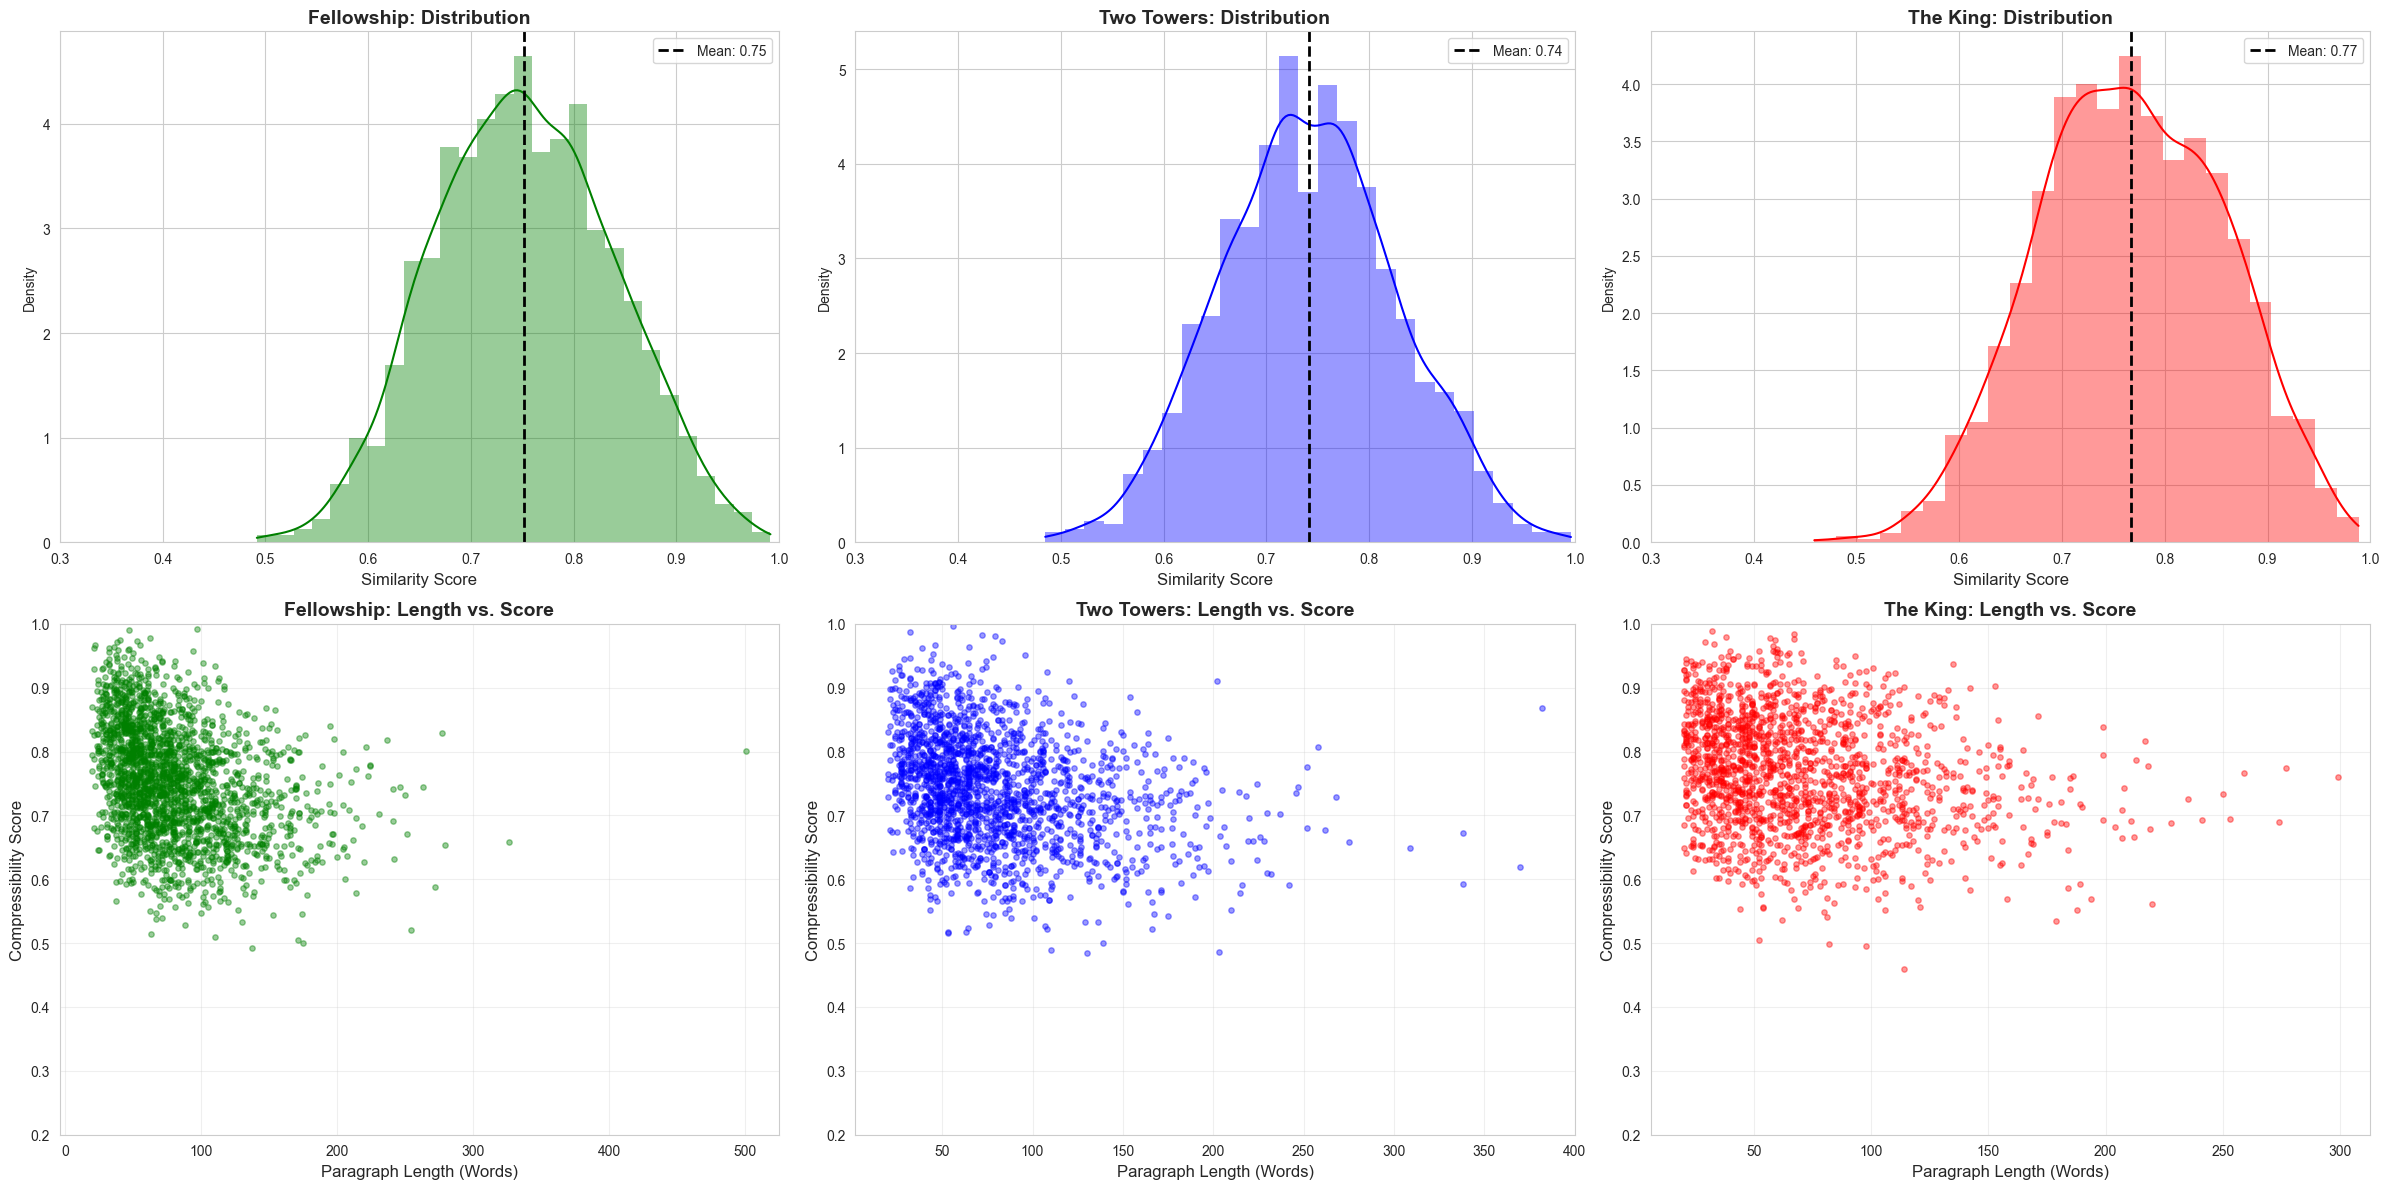

In [9]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from sentence_transformers import SentenceTransformer
import gc

# Load Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- PART 1: VERIFIED LOADING & SPLITTING ---
def load_book(filepath: str) -> str:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return ""
    if 'CHAPTER I' in text:
        text = text[text.find('CHAPTER I'):]
    return text.strip()

def split_into_paragraphs(text: str, book_name: str, min_words: int = 5) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # Strategy 1: Standard Split (Double Newline)
    paras = re.split(r'\n\s*\n+', text)
    mode = "Standard (Double-Space)"
    
    # Strategy 2: Fallback (Single Newline)
    # Checks if Strategy 1 failed to find a realistic number of paragraphs
    if len(paras) < 100:
        paras = text.split('\n')
        mode = "Fallback (Single-Space)"
    
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
            
    print(f"[{book_name}] Split Mode: {mode} | Found: {len(cleaned_paras)} paragraphs")
    return cleaned_paras

# --- PART 2: CENTROID COMPRESSIBILITY METRIC ---
def sentence_split(paragraph: str) -> List[str]:
    # Regex lookbehind to avoid splitting on "Mr." or "Dr."
    pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s'
    sentences = re.split(pattern, paragraph.strip())
    return [s.strip() for s in sentences if s.strip()]

def get_centroid_compressibility(paragraph: str) -> float:
    """
    Calculates how well the 'best' sentence represents the whole paragraph.
    1.0 = The paragraph is redundant (one sentence says it all).
    0.0 = The paragraph is complex/diverse (no single sentence captures the gist).
    """
    sents = sentence_split(paragraph)
    
    # FILTER: Ignore trivial paragraphs (too short or just 1 sentence)
    # This prevents the "1.0 Spike" in the graphs
    if len(sents) < 2 or len(paragraph.split()) < 20:
        return None

    para_emb = model.encode(paragraph)
    sent_embs = model.encode(sents)
    
    # Find max similarity
    scores = []
    for s_emb in sent_embs:
        denom = (np.linalg.norm(para_emb) * np.linalg.norm(s_emb))
        sim = float(np.dot(para_emb, s_emb) / denom) if denom != 0 else 0.0
        scores.append(sim)
        
    return max(scores)

def analyze_book(name, path):
    paras = split_into_paragraphs(load_book(path), name)
    scores = []
    lengths = []
    
    for p in paras:
        score = get_centroid_compressibility(p)
        if score is not None:
            scores.append(score)
            lengths.append(len(p.split()))
            
    return scores, lengths

# --- PART 3: EXECUTION ---
# Note: Ensure paths match your actual folder structure
f_sim, f_len = analyze_book('Fellowship', '../data/Fellowship.txt')
t_sim, t_len = analyze_book('Two Towers', '../data/TwoTowers.txt')
k_sim, k_len = analyze_book('The King', '../data/TheKing.txt')

# --- PART 4: VISUALIZATION (SEPARATE PANELS) ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(24, 12))

data_map = [
    ('Fellowship', 'green', f_sim, f_len),
    ('Two Towers', 'blue', t_sim, t_len),
    ('The King', 'red', k_sim, k_len)
]

# ROW 1: DISTRIBUTIONS
for i, (name, color, sim, _) in enumerate(data_map):
    ax = axes[0, i]
    sns.histplot(sim, ax=ax, color=color, kde=True, stat="density", linewidth=0, alpha=0.4)
    
    mean_val = np.mean(sim)
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    
    ax.set_title(f"{name}: Distribution", fontsize=14, fontweight='bold')
    ax.set_xlabel("Similarity Score", fontsize=12)
    ax.set_xlim(0.3, 1.0)
    ax.legend()

# ROW 2: SCATTER PLOTS
for i, (name, color, sim, length) in enumerate(data_map):
    ax = axes[1, i]
    ax.scatter(length, sim, alpha=0.4, color=color, s=15)
    
    ax.set_title(f"{name}: Length vs. Score", fontsize=14, fontweight='bold')
    ax.set_xlabel("Paragraph Length (Words)", fontsize=12)
    ax.set_ylabel("Compressibility Score", fontsize=12)
    ax.set_ylim(0.2, 1.0)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### How to Interpret These Results

#### Scatter Plots (Similarity vs. Paragraph Length)

**What you're seeing:**
- Each dot = one paragraph
- **X-axis**: Paragraph length in words
- **Y-axis**: Similarity score (0.0 to 1.0)

**Key Patterns:**

1. **Very High Scores (0.9-1.0)**:
   - Most paragraphs cluster in this range!
   - This means the longest sentence usually captures the paragraph's essence very well
   - **Why?** In narrative fiction, paragraphs tend to focus on one scene/moment
   - The longest sentence often describes the main action or idea

2. **Slight Downward Trend**:
   - Longer paragraphs show slightly more variation
   - Some drop to 0.7-0.8 range
   - **Why?** Longer paragraphs may include:
     - Multiple sub-topics (action + dialogue + description)
     - Tangential details that the summary misses
     - Complex narrative threads

3. **Few Low Outliers (below 0.7)**:
   - These are paragraphs where the longest sentence is NOT representative
   - Could be:
     - Dialogue-heavy paragraphs (longest sentence ≠ main point)
     - Lists or enumerations
     - Rapid scene changes

**Comparison Between Books:**
- Both show nearly identical patterns
- Mean similarity around 0.90-0.92
- This confirms Carroll's consistent, focused writing style

---

#### Histogram (Distribution of Compressibility)

**What you're seeing:**
- Shows how common each similarity range is
- Peak around 0.95+ means most paragraphs are HIGHLY compressible

**Key Observations:**

1. **Sharp Peak at High Values (0.90-1.0)**:
   - The vast majority of paragraphs score 0.90+
   - **Interpretation**: Carroll's paragraphs are well-focused and cohesive
   - Each paragraph generally discusses one clear topic/scene
   - This makes his writing easy to read and follow

2. **Very Few Low Values**:
   - Almost no paragraphs below 0.70
   - This is typical of good narrative writing
   - Professional authors maintain topic coherence within paragraphs

3. **Identical Distributions**:
   - Both books overlap almost perfectly
   - Shows Carroll maintained consistent quality across both works

---

### What This Tells Us About Lewis Carroll's Writing:

1. **Highly Cohesive Paragraphs**: 
   - Each paragraph focuses on one clear idea/scene
   - This makes the text easy to follow for young readers

2. **Strong Sentence Structure**:
   - The longest sentences effectively capture paragraph essence
   - Shows careful, deliberate writing (not rambling)

3. **Good Summarization Target**:
   - These texts would be relatively easy for AI systems to summarize
   - High compressibility = clear extraction of key points

4. **RAG-Friendly**:
   - If you were building a search system over these books, paragraphs would work well as chunks
   - Each chunk has a clear, extractable main idea

---

### Comparing to Other Text Types:

**What would we see in different genres?**

- **Academic papers**: Similar high scores (0.85-0.95) - each paragraph makes one clear point
- **Stream-of-consciousness fiction**: Lower scores (0.60-0.80) - paragraphs jump between thoughts
- **Technical manuals**: Very high scores (0.90-0.98) - extremely focused, one-topic paragraphs
- **Social media posts**: Wide variation (0.40-0.95) - inconsistent structure
- **News articles**: High scores (0.85-0.95) - inverted pyramid structure, clear focus

Carroll's scores (0.90-0.95) place him solidly in the "well-structured narrative" category!

---

### Application to Your Projects:

**If you're working with documents:**
- Use compressibility scores to identify well-written vs. poorly-structured paragraphs
- Filter out low-compressibility chunks before feeding to AI systems
- Identify sections that need editing (low scores = unfocused writing)

**If you're building RAG/search systems:**
- Prioritize high-compressibility paragraphs in search results
- They're more likely to contain clear, useful information
- Split or flag low-compressibility paragraphs for special handling

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [ ]:
del fellowship_text, towers_text, king_text
del fellowship_paras, towers_paras, king_paras
del f_sim, f_len, t_sim, t_len, k_sim, k_len
del model
gc.collect()